In [85]:
import pandas as pd
import glob
import os

In [86]:
# Dosyaların bulunduğu klasörü belirt (örneğin, "data" klasörü)
data_path = r"C:\Users\gerha\OneDrive\Desktop\smart-investment-advisor\smart-investment-advisor\datasheets"  # Eğer aynı dizindeyse sadece "./"

# Tüm Excel dosyalarını listele
files = glob.glob(os.path.join(data_path, "*.csv*"))  # .xlsx ve .xls dosyalarını alır

# Boş bir liste oluştur
df_list = []

# Tüm dosyaları döngüyle oku ve listeye ekle
for file in files:
    df = pd.read_csv(file)
    df_list.append(df)

# Tüm DataFrame'leri birleştir
merged_df = pd.concat(df_list, ignore_index=True)

# İlk birkaç satıra bakalım
print(merged_df.head())


         Date   Open   High    Low  Close    Volume  Name
0  2006-01-03  39.69  41.22  38.79  40.91  24232729  AABA
1  2006-01-04  41.22  41.90  40.77  40.97  20553479  AABA
2  2006-01-05  40.93  41.73  40.85  41.53  12829610  AABA
3  2006-01-06  42.88  43.57  42.80  43.21  29422828  AABA
4  2006-01-09  43.10  43.66  42.82  43.42  16268338  AABA


In [87]:
merged_df.to_csv("merged_stock_data.csv", index=False)
merged_df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,39.69,41.22,38.79,40.91,24232729,AABA
1,2006-01-04,41.22,41.90,40.77,40.97,20553479,AABA
2,2006-01-05,40.93,41.73,40.85,41.53,12829610,AABA
3,2006-01-06,42.88,43.57,42.80,43.21,29422828,AABA
4,2006-01-09,43.10,43.66,42.82,43.42,16268338,AABA


In [88]:
company_number = merged_df["Name"].nunique()
print(company_number)

31


In [89]:
company_names = merged_df["Name"].unique()
print(company_names)

['AABA' 'AAPL' 'MMM' 'AXP' 'BA' 'CAT' 'CVX' 'CSCO' 'KO' 'DIS' 'XOM' 'GE'
 'GS' 'HD' 'IBM' 'INTC' 'JNJ' 'JPM' 'MCD' 'MRK' 'MSFT' 'NKE' 'PFE' 'PG'
 'TRV' 'UTX' 'UNH' 'VZ' 'WMT' 'GOOGL' 'AMZN']


In [90]:
merged_df.isnull().sum()

Date       0
Open      74
High      29
Low       59
Close      0
Volume     0
Name       0
dtype: int64

In [91]:
merged_df["Date"] = pd.to_datetime(merged_df["Date"]) #we changed the date format  

In [92]:
#since we have a lot of lost values, we need to fill the missing values with ffill and bfill
merged_df.ffill(inplace=True)  #use the value from the day earlier
merged_df.bfill(inplace=True)  #use the value from the day later
merged_df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [93]:
import matplotlib.pyplot as plt

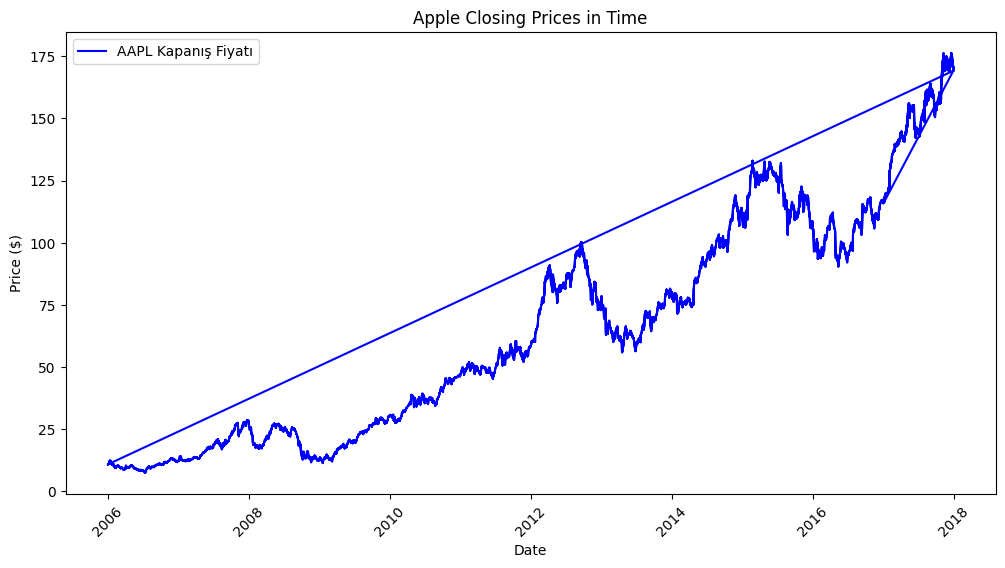

In [94]:
apple_stock = merged_df[merged_df["Name"] == "AAPL"]

plt.figure(figsize=(12, 6))
plt.plot(apple_stock["Date"], apple_stock["Close"], label="AAPL Kapanış Fiyatı", color="blue")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.title("Apple Closing Prices in Time")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [95]:
from sklearn.preprocessing import MinMaxScaler

#Omer bunu kontrol et
#we need to get data ready for LSTM model
merged_df["Date"] = pd.to_datetime(merged_df["Date"]) #we changed the date format  
merged_df.sort_values(by=["Name", "Date"], inplace=True)


scaler = MinMaxScaler(feature_range=(0, 1))
merged_df["Close_Scaled"] = scaler.fit_transform(merged_df[["Close"]])


In [96]:
import numpy as np

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])  # Son 60 günün verisi
        y.append(data[i + seq_length])    # 61. günün fiyatı
    return np.array(X), np.array(y)

# Örnek bir şirket için veriyi alalım (Apple - AAPL)
apple_stock = merged_df[merged_df["Name"] == "AAPL"]

# Yalnızca kapanış fiyatını kullanıyoruz
close_prices = apple_stock["Close"].values

# 60 günlük geçmiş veri kullanarak tahmin yapacağız
seq_length = 60

# Veriyi LSTM için formatlayalım
X, y = create_sequences(close_prices, seq_length)

# LSTM modeli için girdi boyutunu düzenleyelim (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print("X shape:", X.shape)  # (örneğin: 3650, 60, 1)
print("y shape:", y.shape)  # (örneğin: 3650,)


X shape: (6229, 60, 1)
y shape: (6229,)


In [97]:
merged_df["Return"] = merged_df.groupby("Name")["Close"].pct_change()  # Günlük getiriyi hesapla
merged_df["Volatility"] = merged_df.groupby("Name")["Return"].rolling(window=30).std().reset_index(0, drop=True)  # 30 günlük volatilite

# Volatilite yüzdelik (percentile) eşiklerini belirleyelim
low_threshold = merged_df["Volatility"].quantile(0.33)  # İlk %33
high_threshold = merged_df["Volatility"].quantile(0.66) # %66'nın üstü

# Risk seviyelerini güncelleyelim
def classify_risk(vol):
    if vol < low_threshold:
        return "Low"
    elif vol < high_threshold:
        return "Medium"
    else:
        return "High"

# Güncellenmiş risk seviyelerini atayalım
merged_df["Risk_Level"] = merged_df["Volatility"].apply(classify_risk)

# Sonuçları görelim
print(merged_df[["Name", "Volatility", "Risk_Level"]].drop_duplicates())


       Name  Volatility Risk_Level
0      AABA         NaN       High
15     AABA    0.026008       High
16     AABA    0.026383       High
17     AABA    0.026160       High
18     AABA    0.024717       High
...     ...         ...        ...
36231   XOM    0.002978        Low
36232   XOM    0.002884        Low
36233   XOM    0.002814        Low
36234   XOM    0.002724        Low
36235   XOM    0.002815        Low

[93519 rows x 3 columns]


In [98]:


# 📌 Günlük getiri (return) hesaplayalım
merged_df["Return"] = merged_df.groupby("Name")["Close"].pct_change()

# 📌 Volatiliteyi (standart sapma) hesaplayalım
volatility = merged_df.groupby("Name")["Return"].std()

# 📌 Volatiliteyi DataFrame'e ekleyelim
merged_df["Volatility"] = merged_df["Name"].map(volatility)

# 📌 Risk seviyelerini belirleme (Volatiliteye göre)
def classify_risk(vol):
    if vol < 0.01:
        return "Low"
    elif vol < 0.03:
        return "Medium"
    else:
        return "High"

# 📌 Risk seviyesini belirleyelim
merged_df["Risk_Level"] = merged_df["Volatility"].apply(classify_risk)

# 📌 Risk seviyelerini kontrol edelim
print(merged_df[["Name", "Volatility", "Risk_Level"]].drop_duplicates())


        Name  Volatility Risk_Level
0       AABA    0.016865     Medium
3019    AAPL    0.014158     Medium
93612   AMZN    0.017477     Medium
9058     AXP    0.016114     Medium
15097     BA    0.012125     Medium
18117    CAT    0.013955     Medium
24157   CSCO    0.012734     Medium
21137    CVX    0.011571     Medium
30196    DIS    0.011499     Medium
36236     GE    0.012933     Medium
90593  GOOGL    0.012787     Medium
39256     GS    0.016568     Medium
42276     HD    0.011384     Medium
45296    IBM    0.009372        Low
48316   INTC    0.012439     Medium
51335    JNJ    0.006870        Low
54355    JPM    0.017885     Medium
27176     KO    0.007730        Low
57375    MCD    0.008111        Low
6038     MMM    0.009361        Low
60395    MRK    0.010961     Medium
63414   MSFT    0.011746     Medium
66433    NKE    0.011837     Medium
69453    PFE    0.009625        Low
72473     PG    0.007446        Low
75493    TRV    0.012189     Medium
81533    UNH    0.014290    

In [99]:
#classifying risk levels
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Sadece kapanış fiyatı ve hacim gibi finansal verileri alalım
features = ["Close", "Volume"]
X = merged_df[features]
y = merged_df["Risk_Level"]  # Risk seviyesini içeren bir kolon olmalı

# Risk seviyelerini numerik hale getirelim
le = LabelEncoder()
y = le.fit_transform(y)

# Eğitim ve test verisini ayıralım
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest modelini eğit
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Modeli test et
accuracy = clf.score(X_test, y_test)
print("Model accuracy:", accuracy)

Model accuracy: 0.943591189969488


In [100]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))   #1. Classification Report
print(confusion_matrix(y_test, y_pred))         #2. Confusion Matrix

#f1 score = Precision ve Recall’ün harmonik ortalaması. Eğer precision ve recall arasında dengesizlik varsa, F1-score daha iyi bir gösterge olur.

              precision    recall  f1-score   support

           0       0.92      0.89      0.90     11243
           1       0.95      0.97      0.96     27758

    accuracy                           0.94     39001
   macro avg       0.93      0.93      0.93     39001
weighted avg       0.94      0.94      0.94     39001

[[ 9962  1281]
 [  919 26839]]
